### Importaciones

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from category_encoders import OneHotEncoder, MEstimateEncoder, GLMMEncoder, OrdinalEncoder, CatBoostEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import HuberRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, roc_auc_score, roc_curve
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

sns.set_theme(style = 'white', palette = 'colorblind')
pal = sns.color_palette('colorblind')

pd.set_option('display.max_rows', 100)

### Cargamos datos

In [17]:
train = pd.read_csv('data/train.csv')
train

id        date    country         store  \
0            0  2017-01-01  Argentina  Kaggle Learn   
1            1  2017-01-01  Argentina  Kaggle Learn   
2            2  2017-01-01  Argentina  Kaggle Learn   
3            3  2017-01-01  Argentina  Kaggle Learn   
4            4  2017-01-01  Argentina  Kaggle Learn   
...        ...         ...        ...           ...   
136945  136945  2021-12-31      Spain     Kagglazon   
136946  136946  2021-12-31      Spain     Kagglazon   
136947  136947  2021-12-31      Spain     Kagglazon   
136948  136948  2021-12-31      Spain     Kagglazon   
136949  136949  2021-12-31      Spain     Kagglazon   

                                               product  num_sold  
0                    Using LLMs to Improve Your Coding        63  
1                        Using LLMs to Train More LLMs        66  
2       Using LLMs to Win Friends and Influence People         9  
3           Using LLMs to Win More Kaggle Competitions        59  
4                           Using LLMs to Write Better        49  
...                                                ...       ...  
136945               Using LLMs to Improve Your Coding       700  
136946                   Using LLMs to Train More LLMs       752  
136947  Using LLMs to Win Friends and Influence People       111  
136948      Using LLMs to Win More Kaggle Competitions       641  
136949                      Using LLMs to Write Better       539  

[136950 rows x 6 columns]

In [18]:
test = pd.read_csv('data/test.csv')
test

id        date    country         store  \
0      136950  2022-01-01  Argentina  Kaggle Learn   
1      136951  2022-01-01  Argentina  Kaggle Learn   
2      136952  2022-01-01  Argentina  Kaggle Learn   
3      136953  2022-01-01  Argentina  Kaggle Learn   
4      136954  2022-01-01  Argentina  Kaggle Learn   
...       ...         ...        ...           ...   
27370  164320  2022-12-31      Spain     Kagglazon   
27371  164321  2022-12-31      Spain     Kagglazon   
27372  164322  2022-12-31      Spain     Kagglazon   
27373  164323  2022-12-31      Spain     Kagglazon   
27374  164324  2022-12-31      Spain     Kagglazon   

                                              product  
0                   Using LLMs to Improve Your Coding  
1                       Using LLMs to Train More LLMs  
2      Using LLMs to Win Friends and Influence People  
3          Using LLMs to Win More Kaggle Competitions  
4                          Using LLMs to Write Better  
...                                               ...  
27370               Using LLMs to Improve Your Coding  
27371                   Using LLMs to Train More LLMs  
27372  Using LLMs to Win Friends and Influence People  
27373      Using LLMs to Win More Kaggle Competitions  
27374                      Using LLMs to Write Better  

[27375 rows x 5 columns]

In [19]:
# Estudiamos los valores únicos
desc = pd.DataFrame(index = list(train))
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] / len(data_train) * 100
desc['null'] = train.isnull().sum()
desc['type'] = train.dtypes
desc = pd.concat([desc, train.describe().T.drop('count', axis = 1)], axis = 1) # Concatenamos con describe
desc

count  nunique     %unique  null    type          mean  \
id        136950   136950  100.000000     0   int64  68474.500000   
date      136950     1826    1.333333     0  object           NaN   
country   136950        5    0.003651     0  object           NaN   
store     136950        3    0.002191     0  object           NaN   
product   136950        5    0.003651     0  object           NaN   
num_sold  136950     1028    0.750639     0   int64    165.522636   

                   std  min       25%      50%        75%       max  
id        39534.204020  0.0  34237.25  68474.5  102711.75  136949.0  
date               NaN  NaN       NaN      NaN        NaN       NaN  
country            NaN  NaN       NaN      NaN        NaN       NaN  
store              NaN  NaN       NaN      NaN        NaN       NaN  
product            NaN  NaN       NaN      NaN        NaN       NaN  
num_sold    183.691575  2.0     46.00     98.0     184.00    1380.0

### Variables categóricas y numéricas
Tendremos que localizarlas y trabajar con ellas

In [20]:
categorical_features = ['country', 'store', 'product']
numerical_features = test.drop(categorical_features, axis = 1).columns

### Formato fecha
Es importante reformatear la fecha y poder visualizarla

In [21]:
train.date = pd.to_datetime(train.date, format = '%Y-%m-%d')
test.date = pd.to_datetime(test.date, format = '%Y-%m-%d')

### Distribución de las ventas

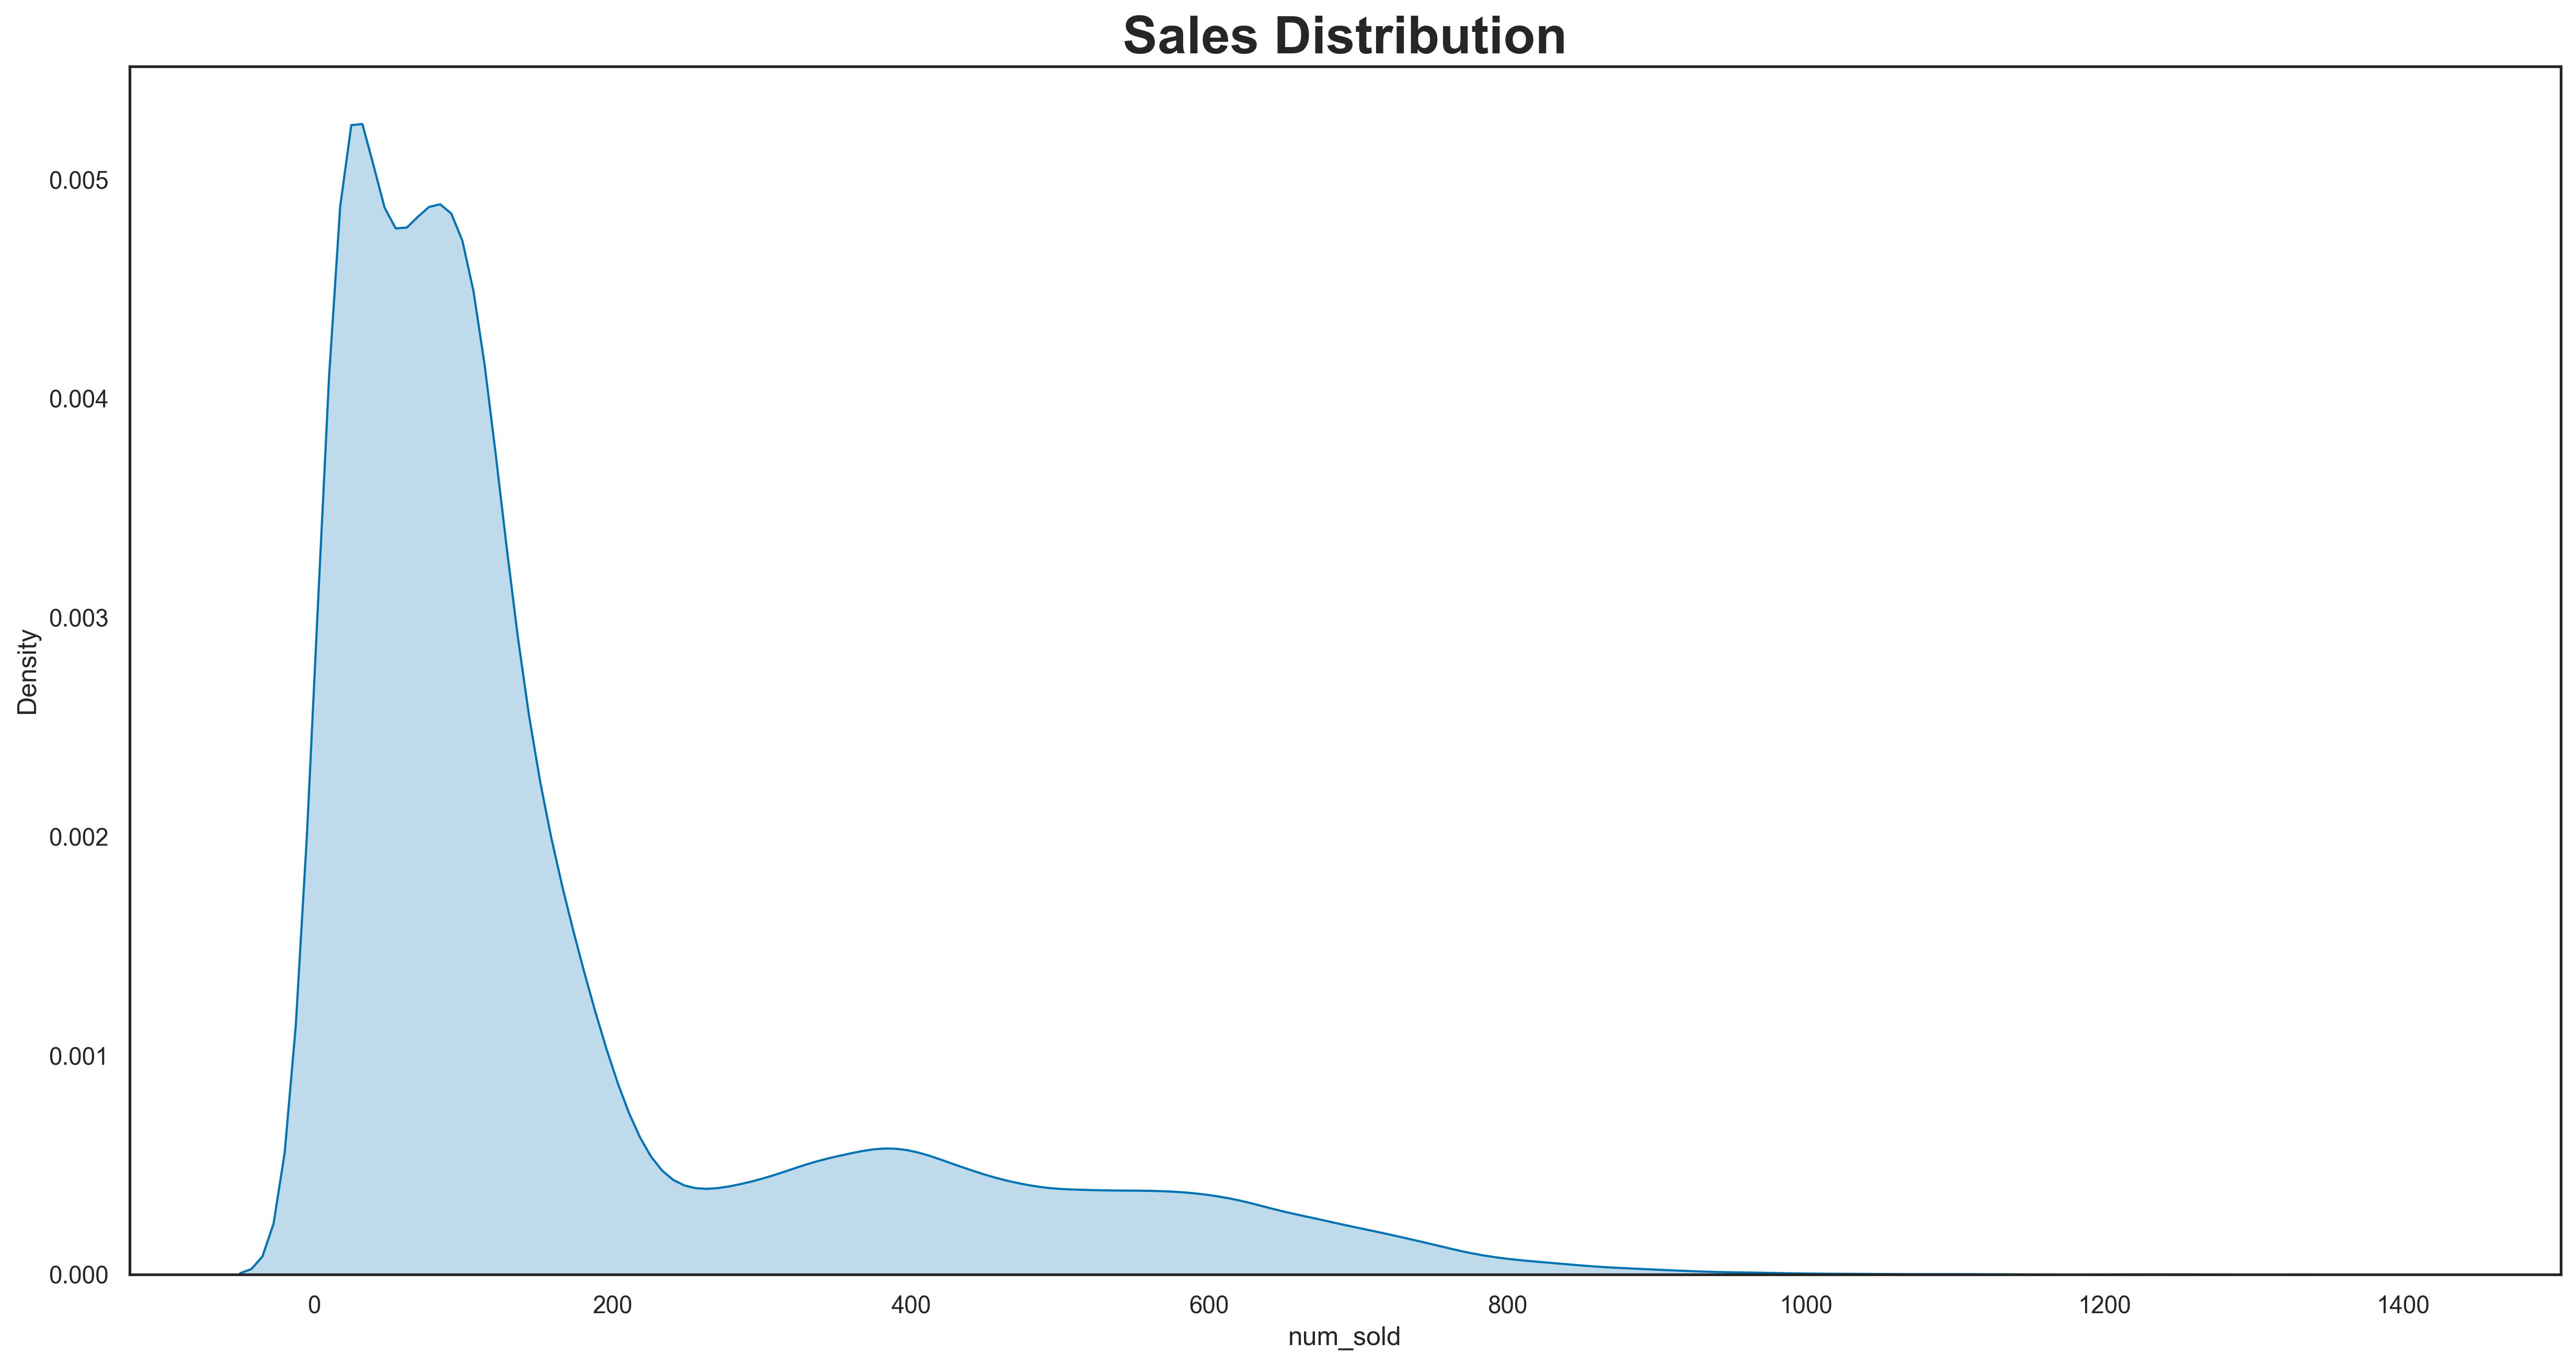

In [22]:
plt.figure(figsize = (20, 10), dpi = 300)

sns.kdeplot(data = train, x = 'num_sold', fill = True)
    
plt.title('Sales Distribution', fontsize = 24, fontweight = 'bold')
plt.show()

### Ventas a lo largo del tiempo
Vemos que siempre hay una subida coincidiendo con Navidades. Además, se ve el efecto de la pandemia en las ventas.

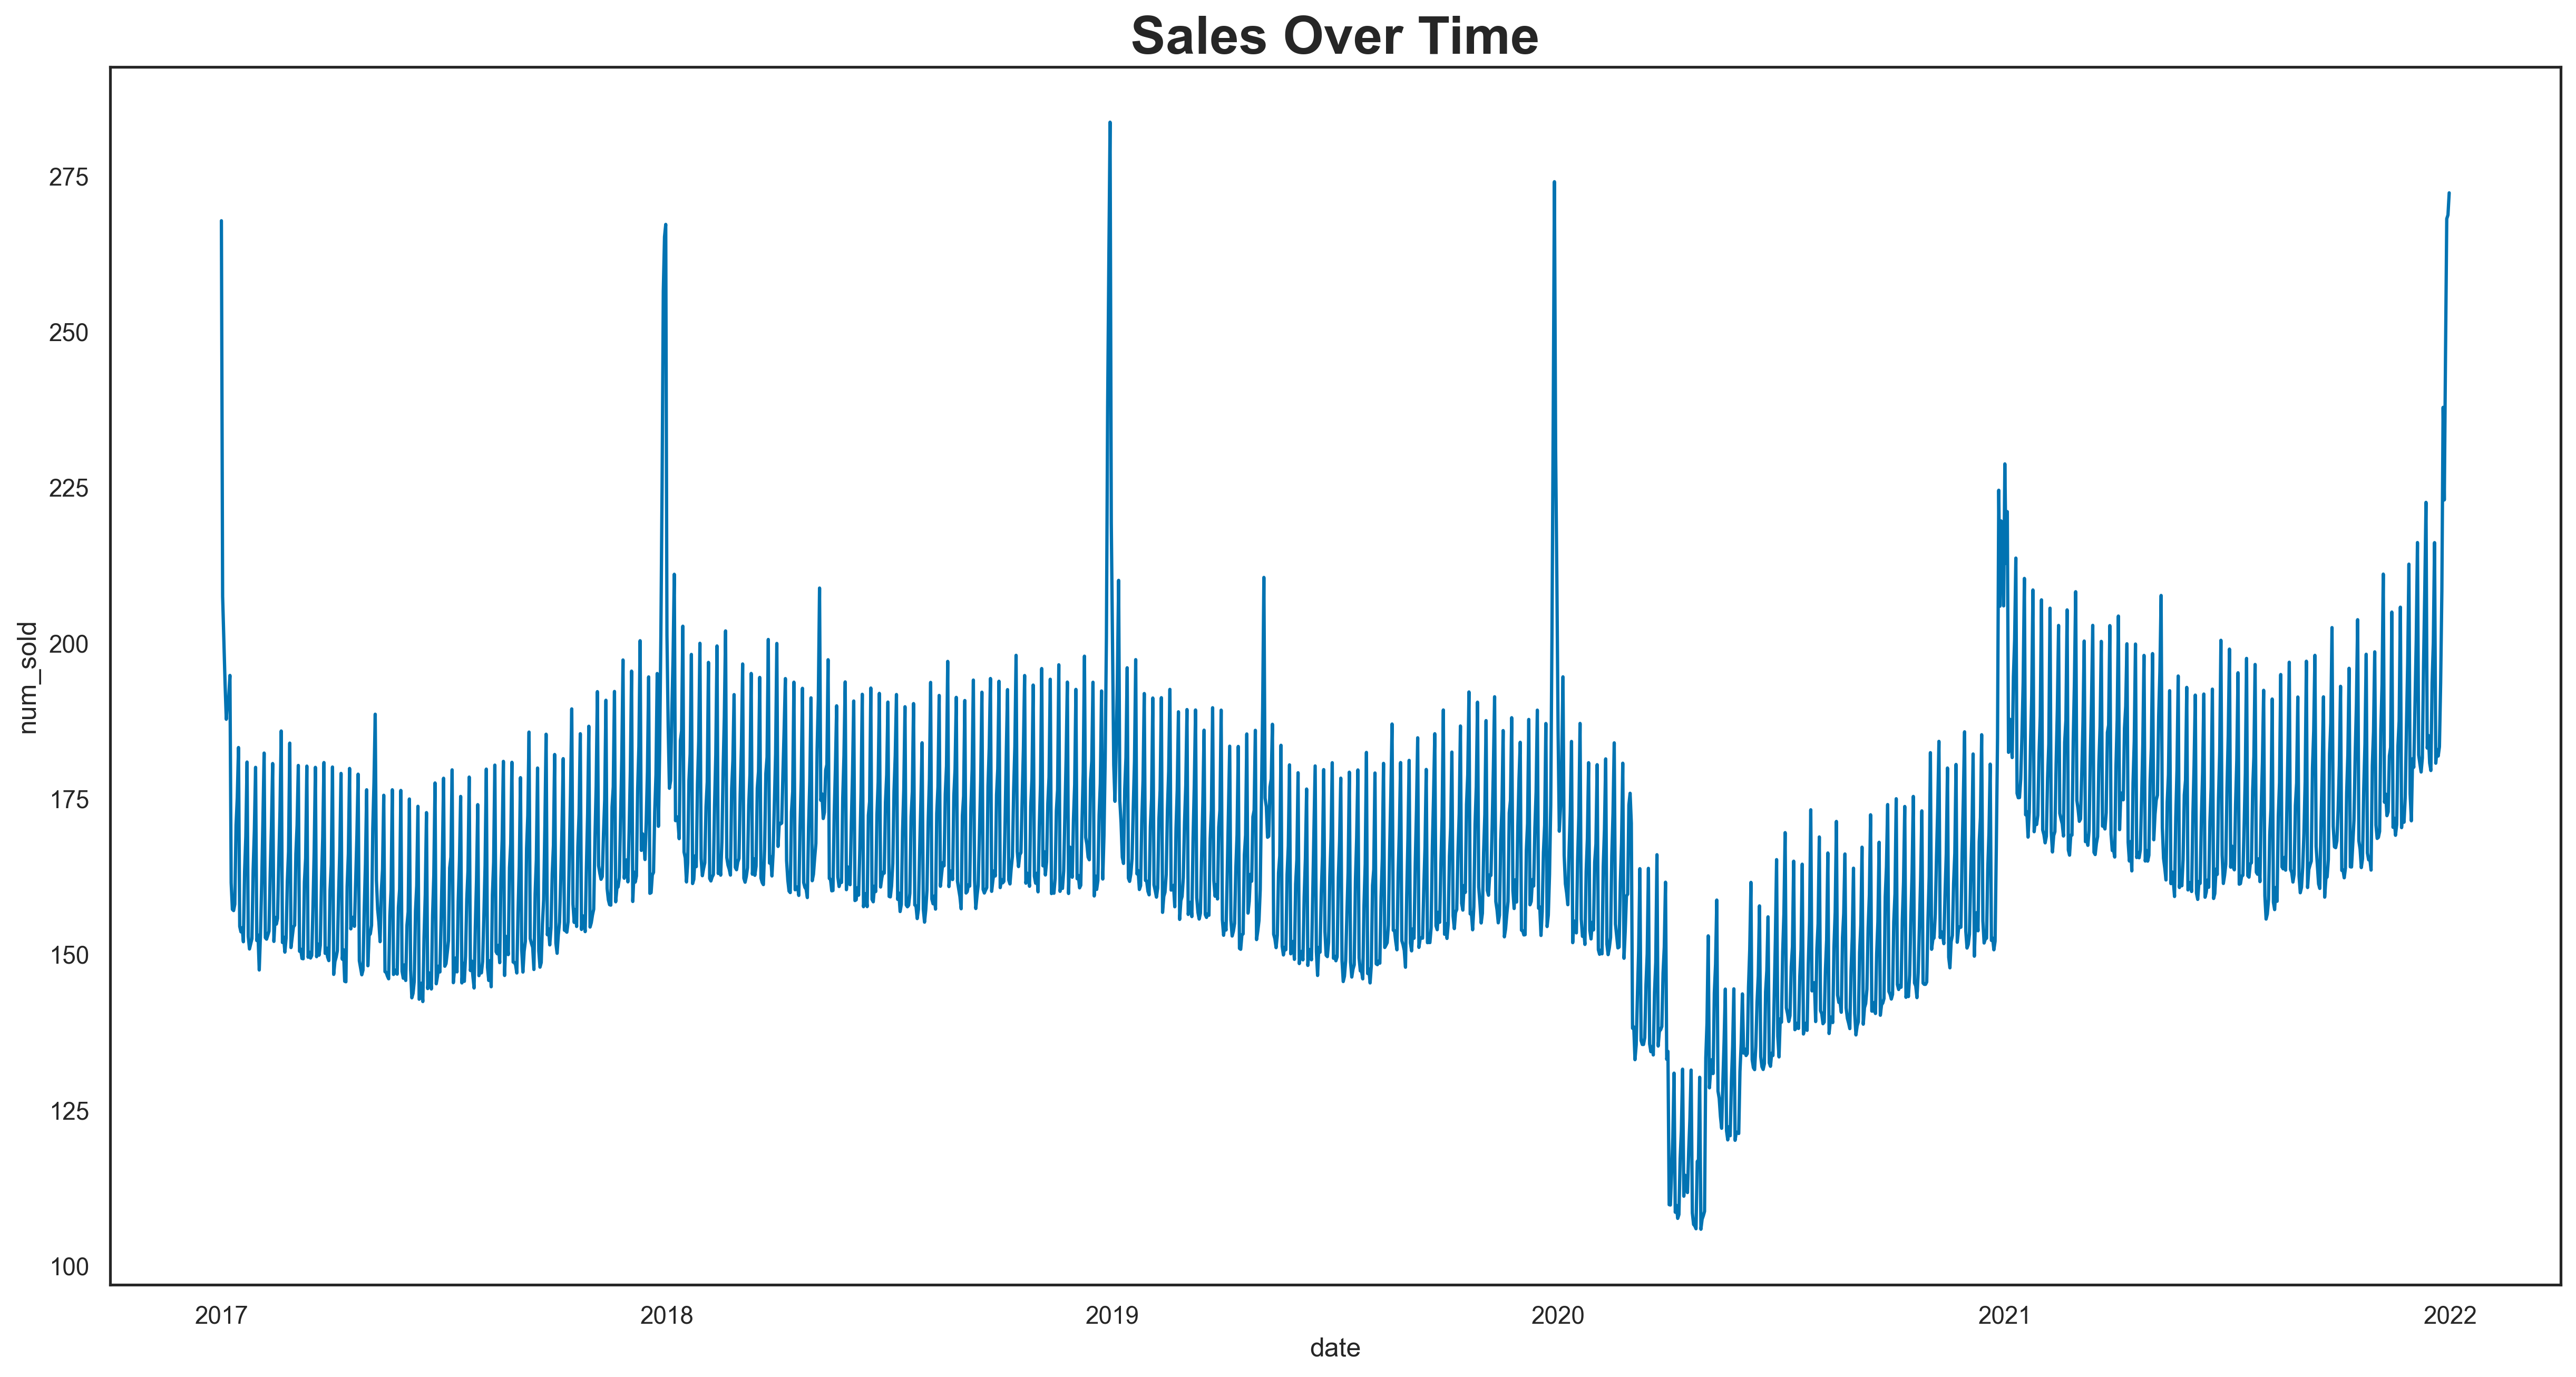

In [23]:
plt.figure(figsize = (20, 10), dpi = 300)

sns.lineplot(data = train, x = 'date', y = 'num_sold', errorbar = None)
    
plt.title('Sales Over Time', fontsize = 24, fontweight = 'bold')
plt.show()

### Ventas por país

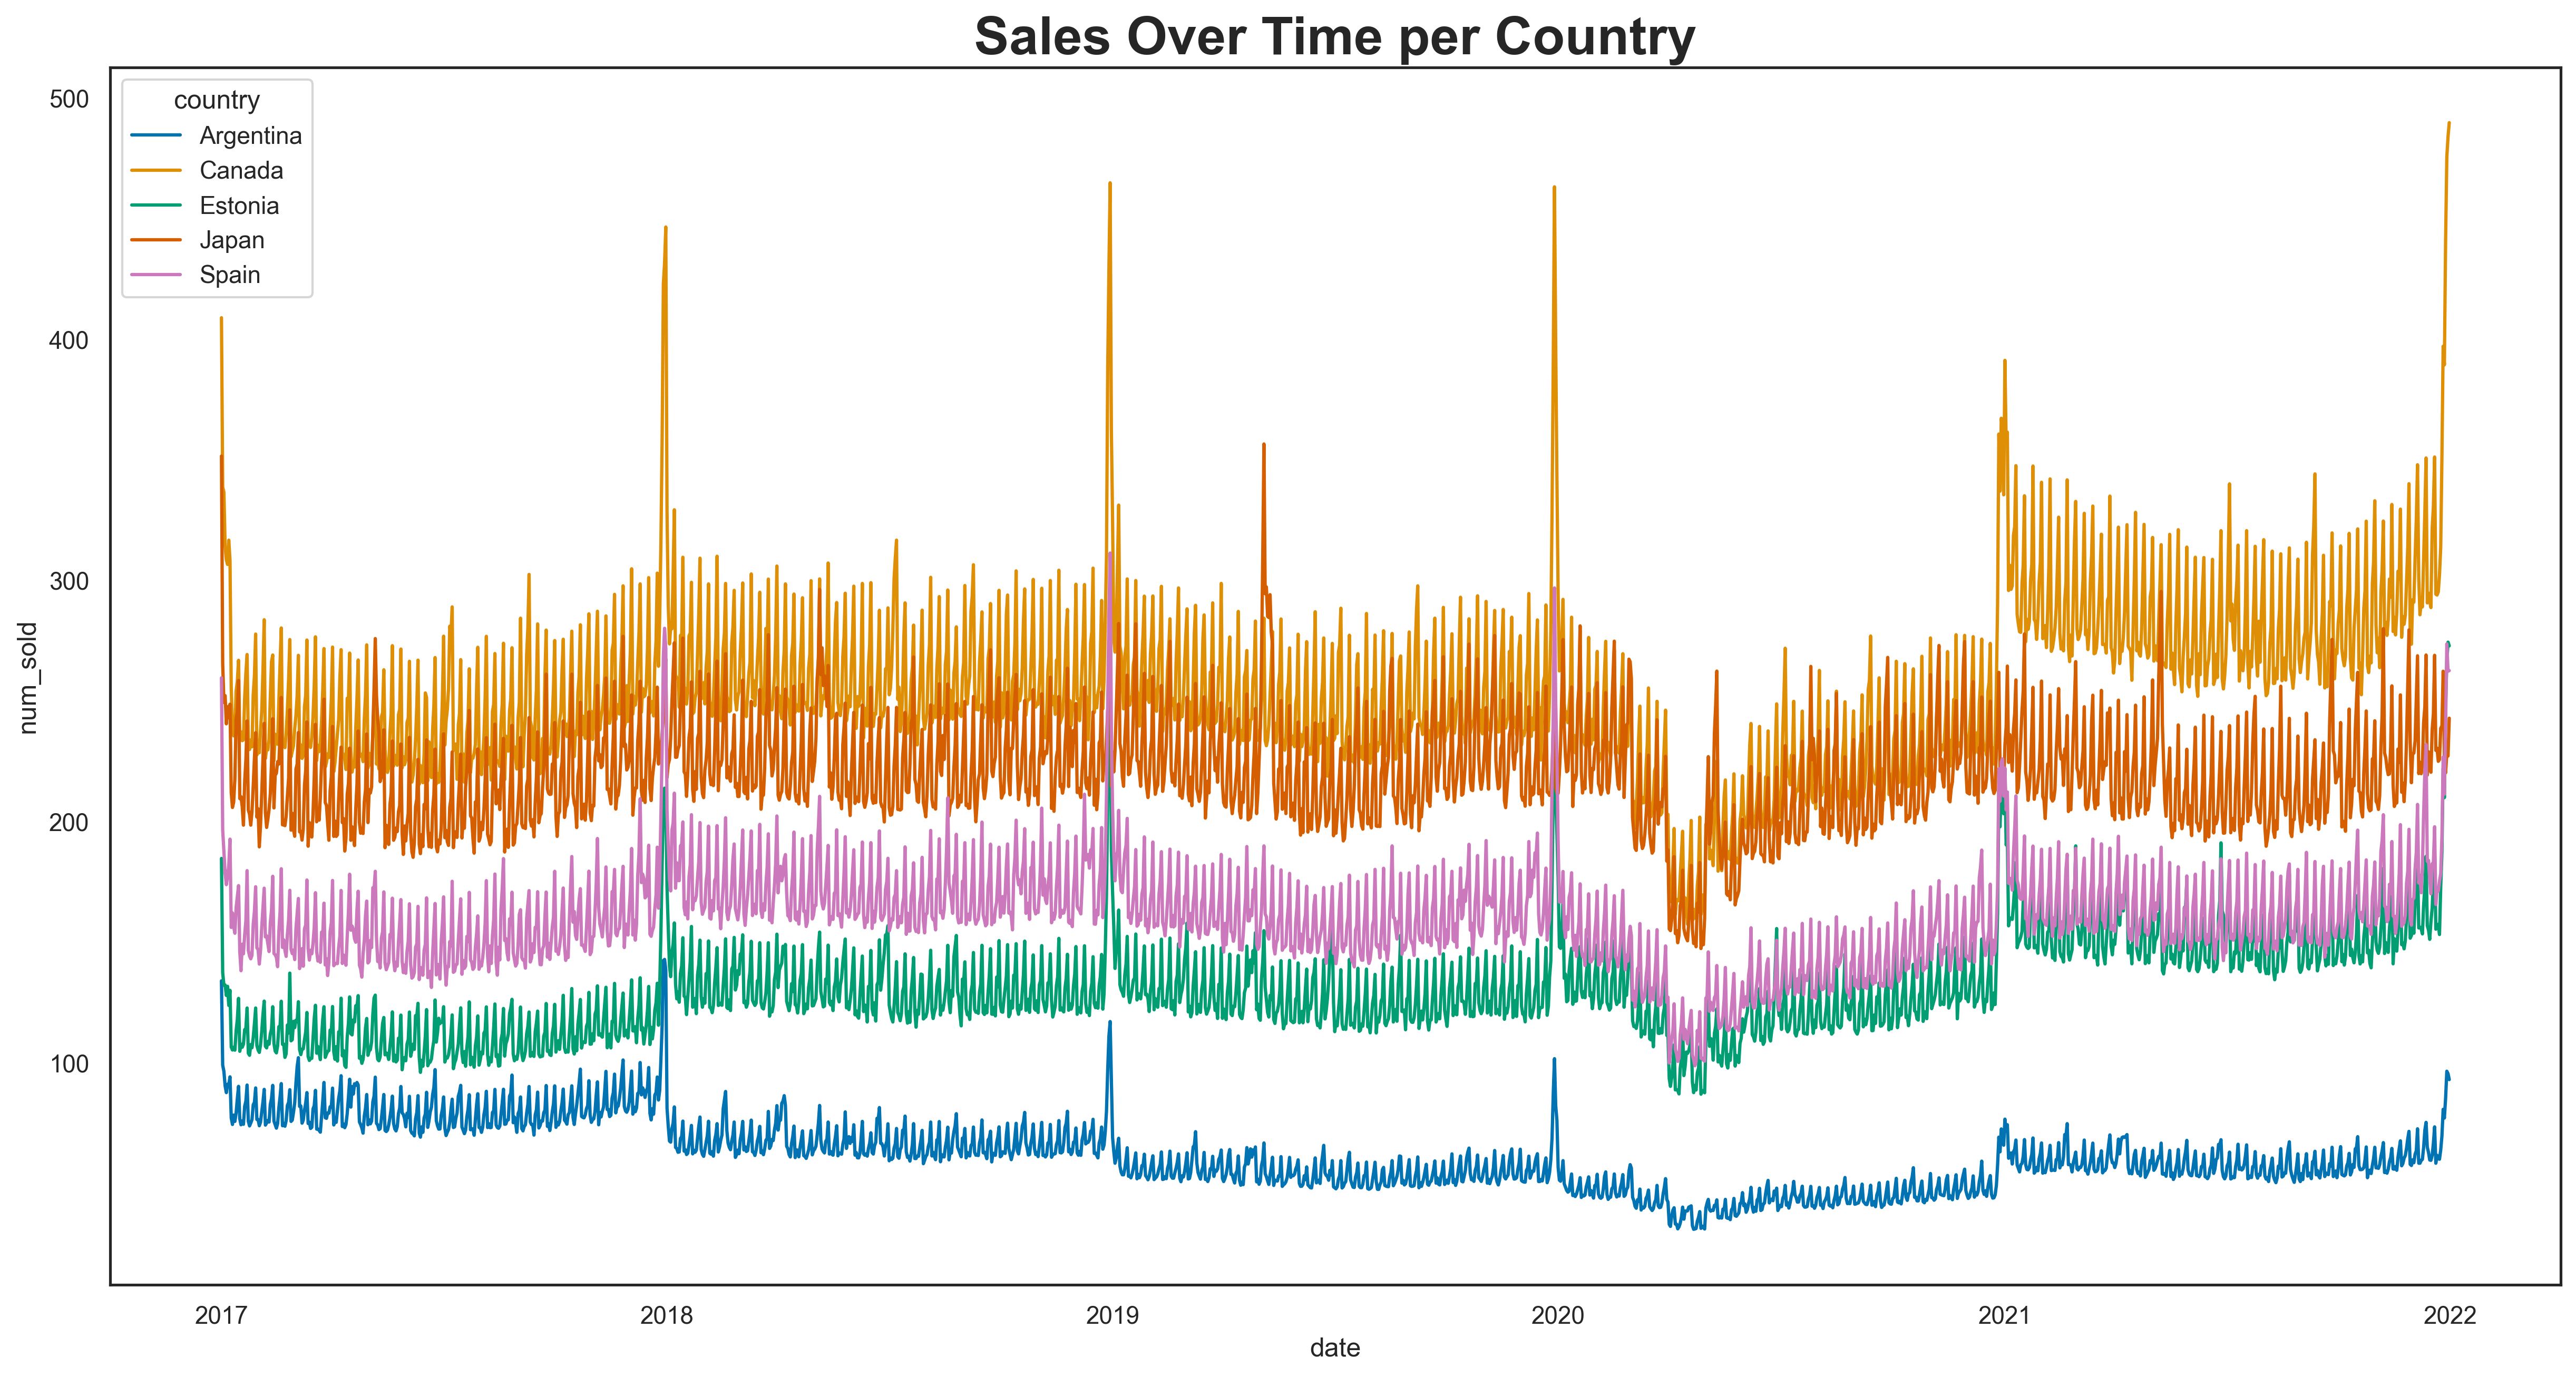

In [24]:
plt.figure(figsize = (20, 10), dpi = 300)

sns.lineplot(data = train, x = 'date', y = 'num_sold', hue = 'country', errorbar = None)
    
plt.title('Sales Over Time per Country', fontsize = 24, fontweight = 'bold')
plt.show()

### Ventas por tienda

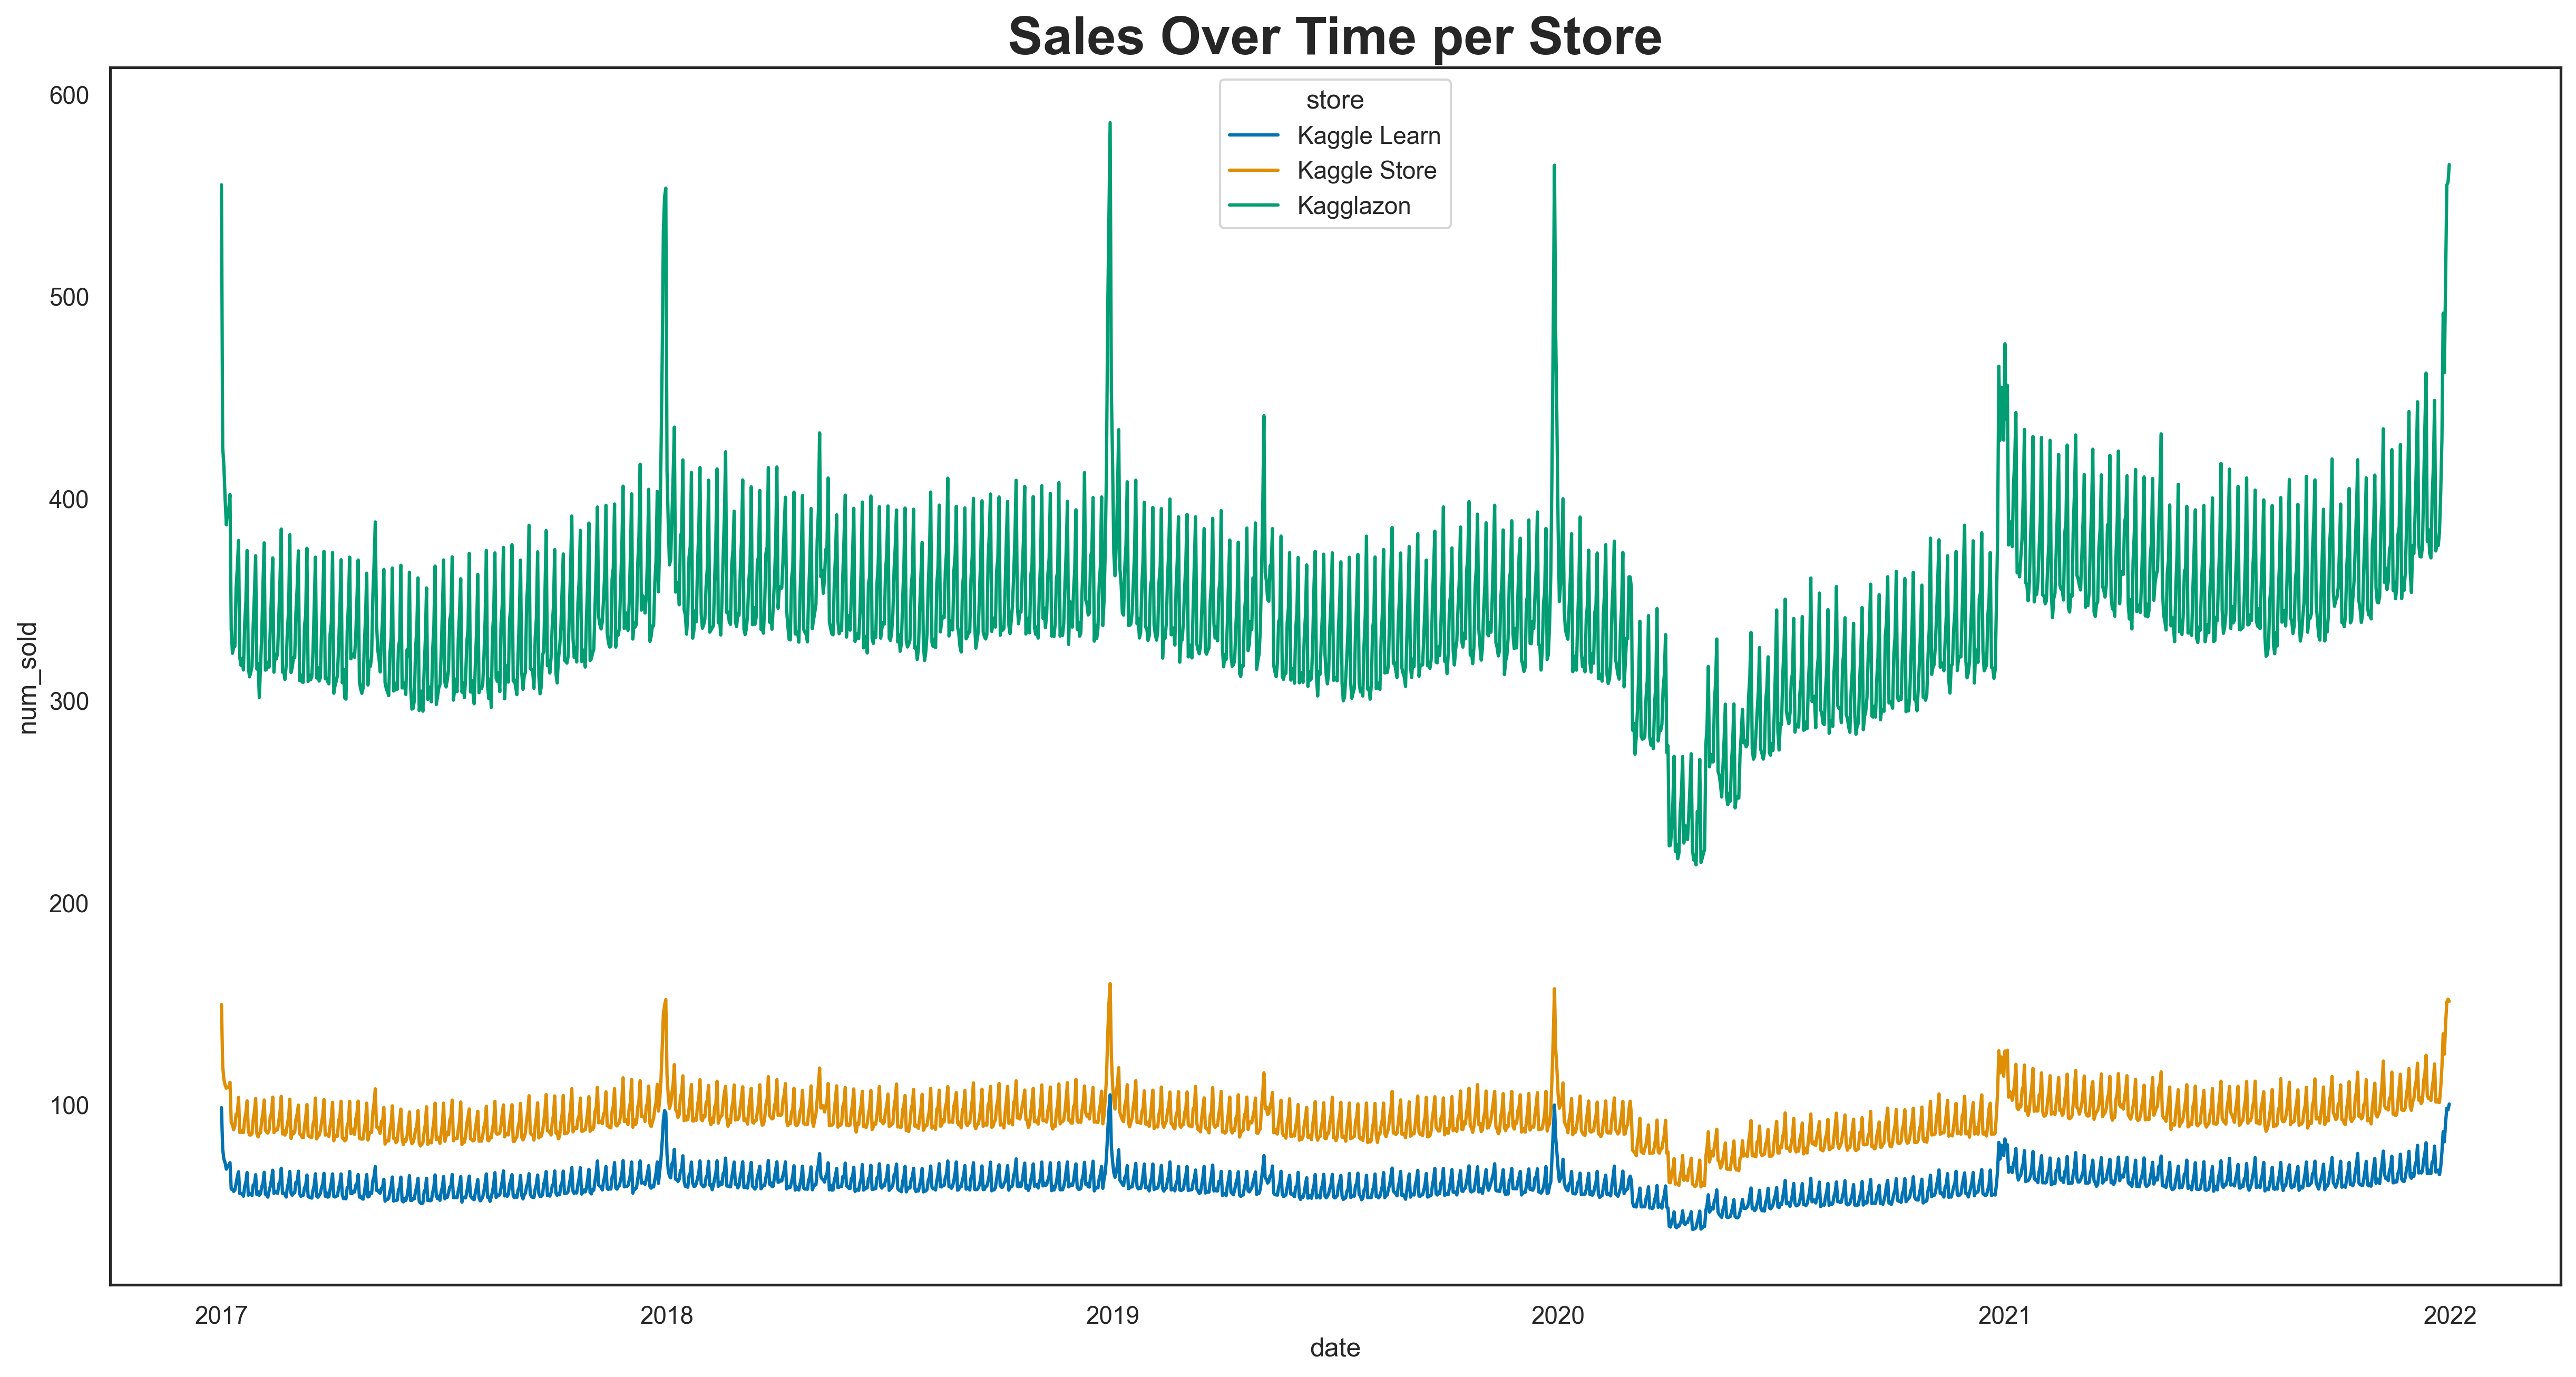

In [25]:
plt.figure(figsize = (20, 10), dpi = 300)

sns.lineplot(data = train, x = 'date', y = 'num_sold', hue = 'store', errorbar = None)
    
plt.title('Sales Over Time per Store', fontsize = 24, fontweight = 'bold')
plt.show()

### Ventas por producto
En este punto podemos ver distintas tendencias por producto y momento del año

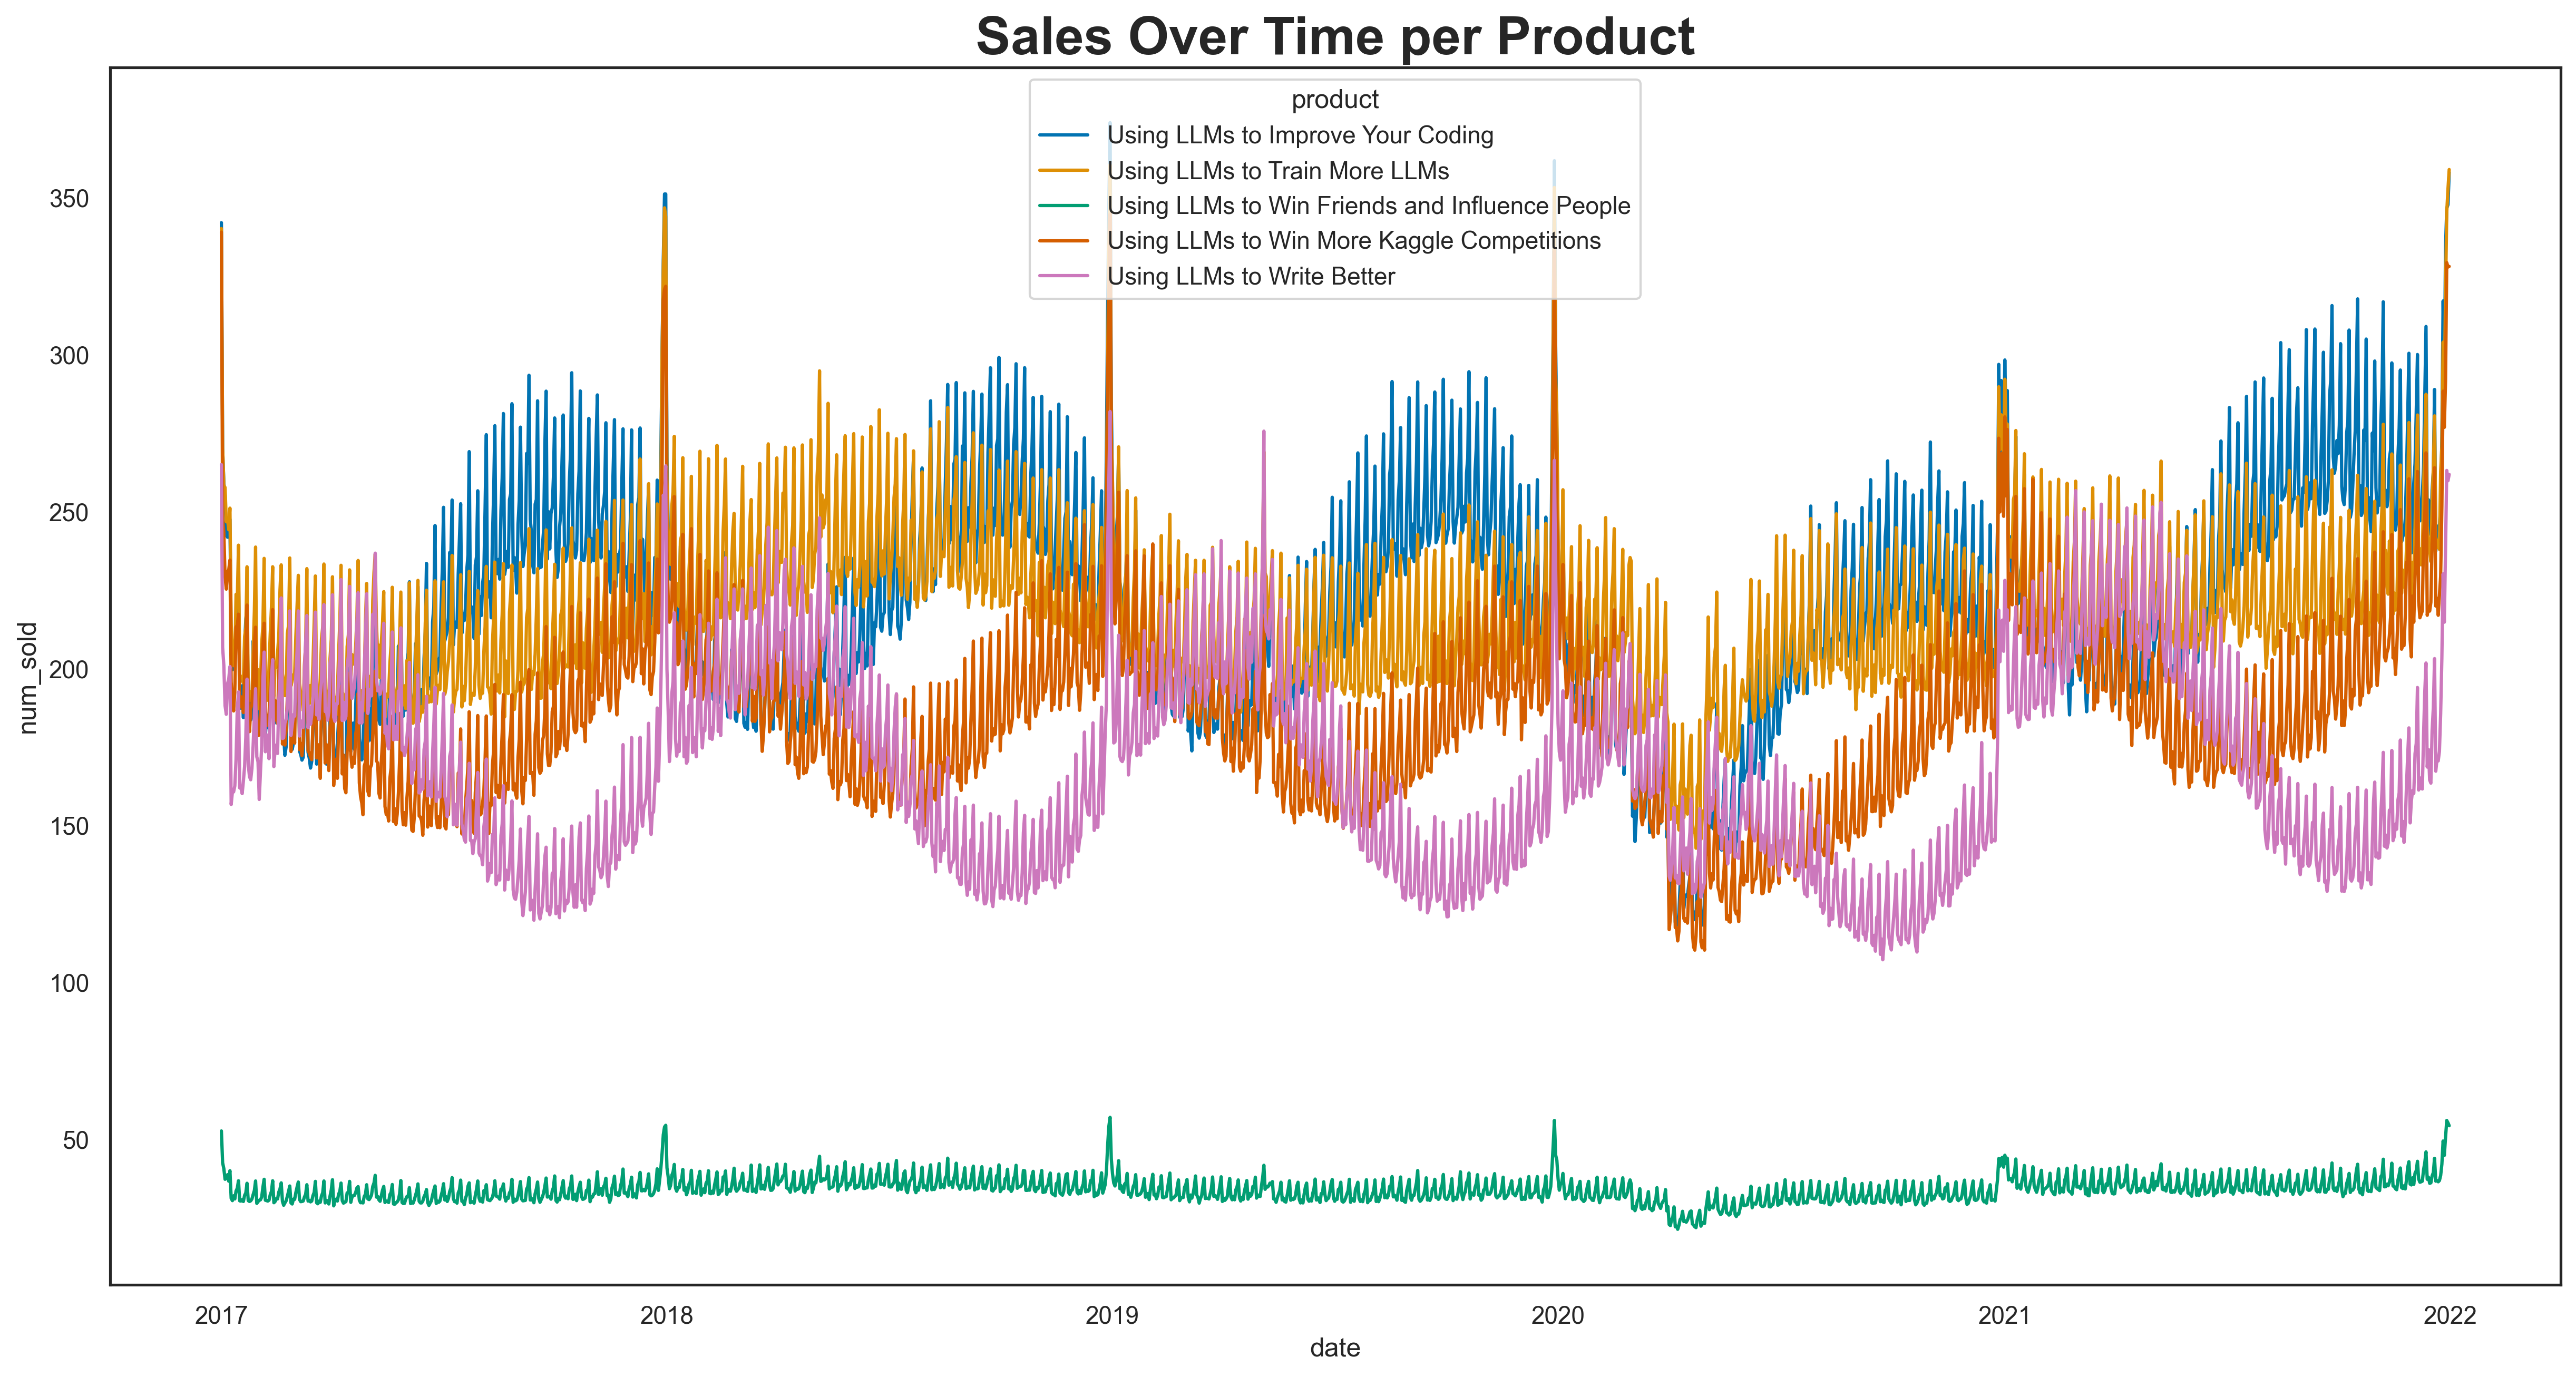

In [26]:
plt.figure(figsize = (20, 10), dpi = 300)

sns.lineplot(data = train, x = 'date', y = 'num_sold', hue = 'product', errorbar = None)
    
plt.title('Sales Over Time per Product', fontsize = 24, fontweight = 'bold')
plt.show()

### Distribución de las variables categóricas en train y test
Vemos que la representación es similar

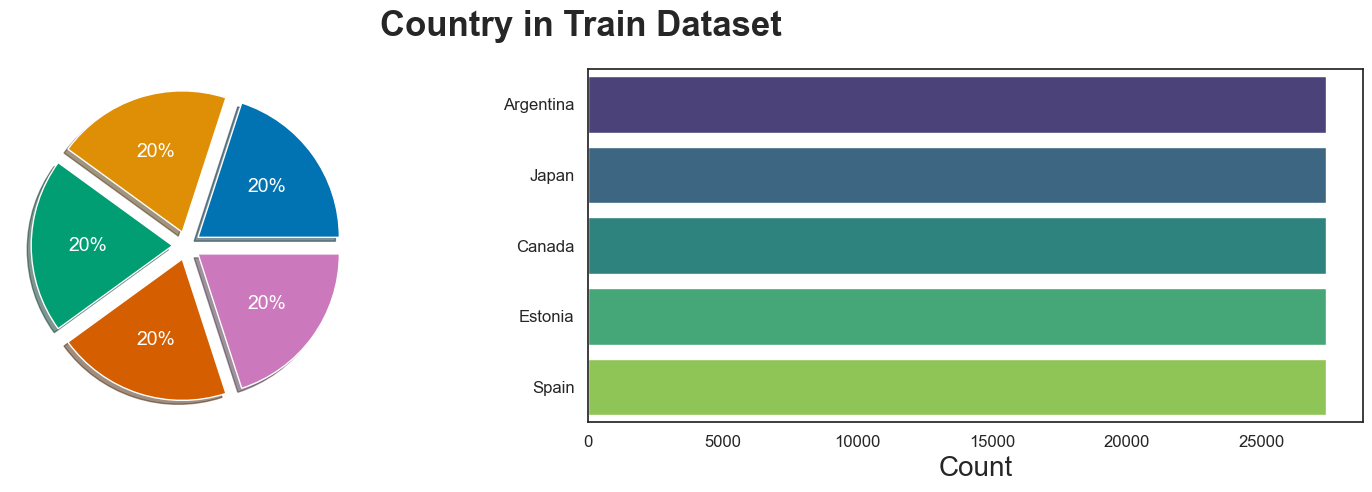

In [27]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten()

ax[0].pie(
    train['country'].value_counts(), 
    shadow = True, 
    explode = [.1 for i in range(0, 5)], 
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data = train, y = 'country', ax = ax[1], palette = 'viridis', order = train['country'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Country in Train Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

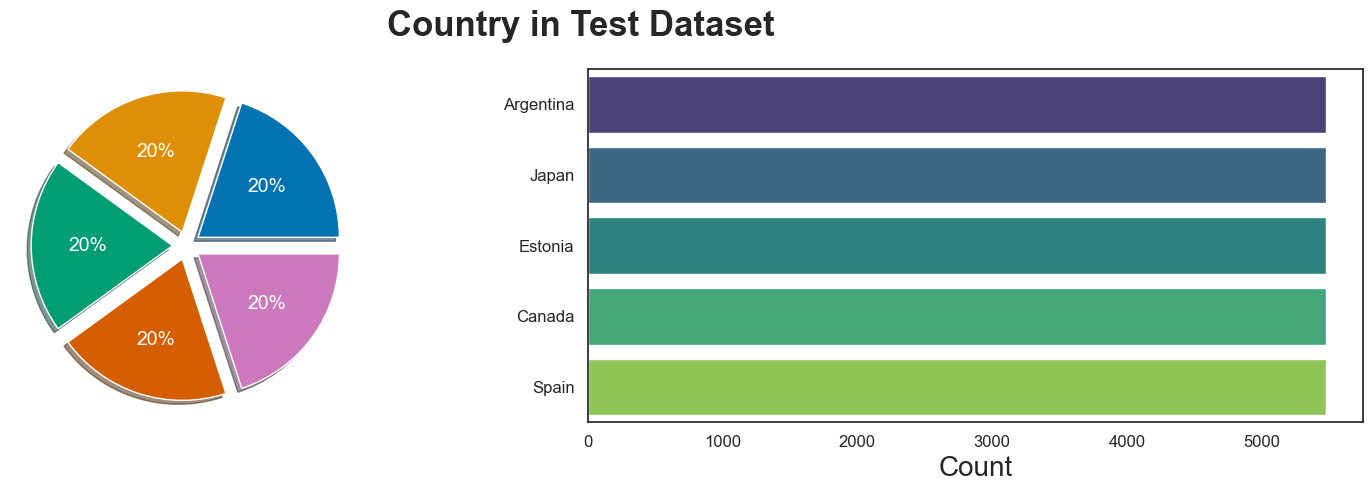

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten()

ax[0].pie(
    test['country'].value_counts(), 
    shadow = True, 
    explode = [.1 for i in range(0, 5)], 
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data = test, y = 'country', ax = ax[1], palette = 'viridis', order = test['country'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Country in Test Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

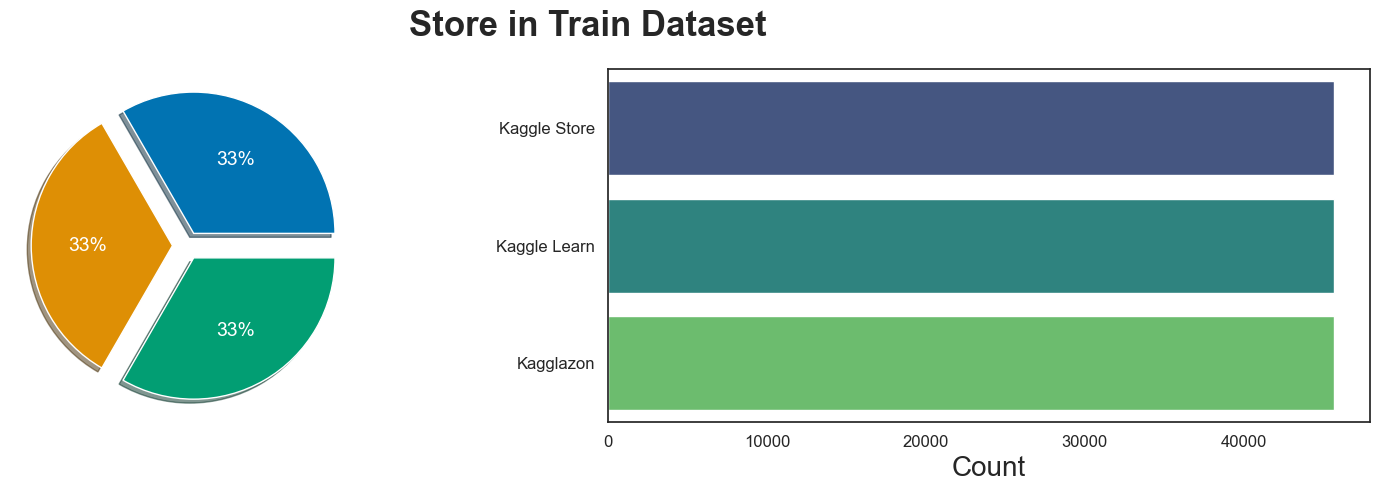

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten()

ax[0].pie(
    train['store'].value_counts(), 
    shadow = True, 
    explode = [.1 for i in range(0, 3)], 
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data = train, y = 'store', ax = ax[1], palette = 'viridis', order = train['store'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Store in Train Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

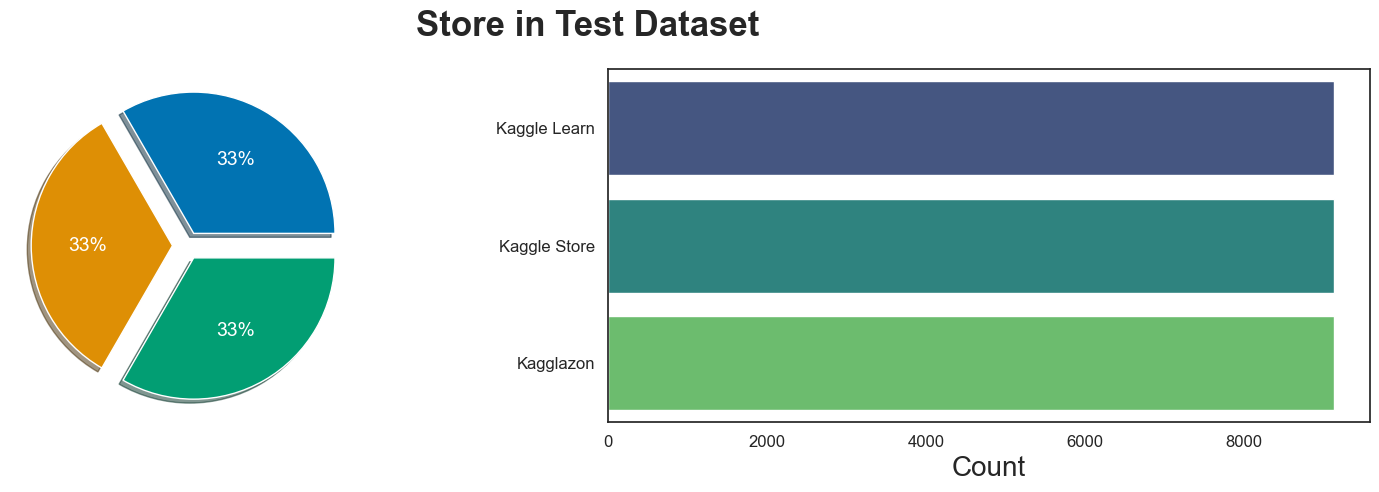

In [30]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten()

ax[0].pie( 
    test['store'].value_counts(), 
    shadow = True, 
    explode = [.1 for i in range(0, 3)], 
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data = test, y = 'store', ax = ax[1], palette = 'viridis', order = test['store'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Store in Test Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

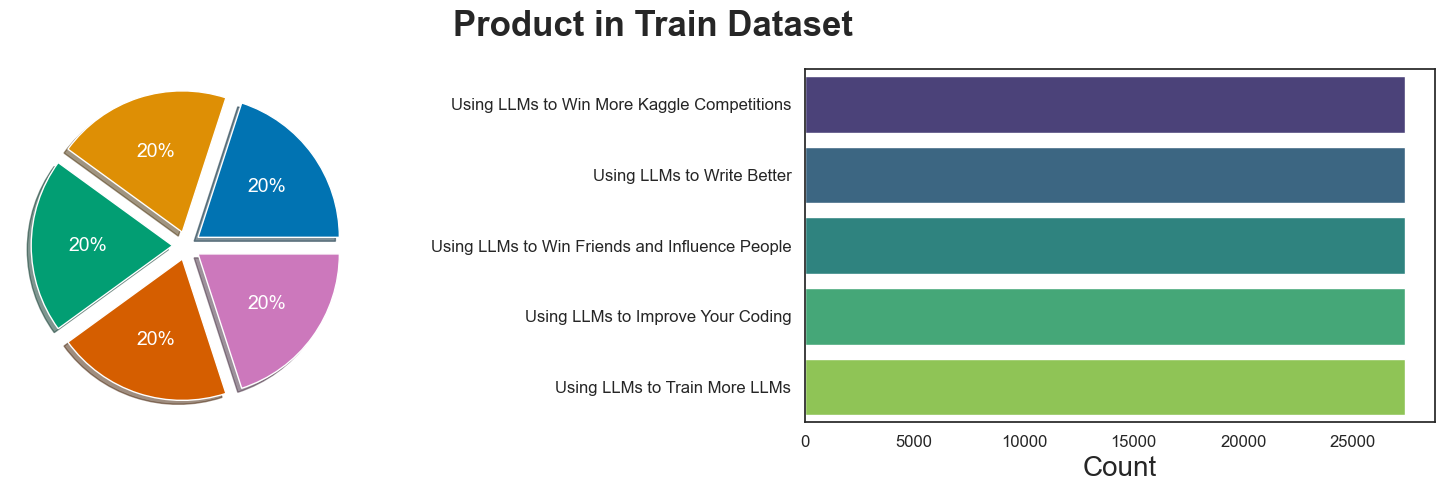

In [31]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten()

ax[0].pie(
    train['product'].value_counts(), 
    shadow = True, 
    explode = [.1 for i in range(0, 5)], 
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data = train, y = 'product', ax = ax[1], palette = 'viridis', order = train['product'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Product in Train Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

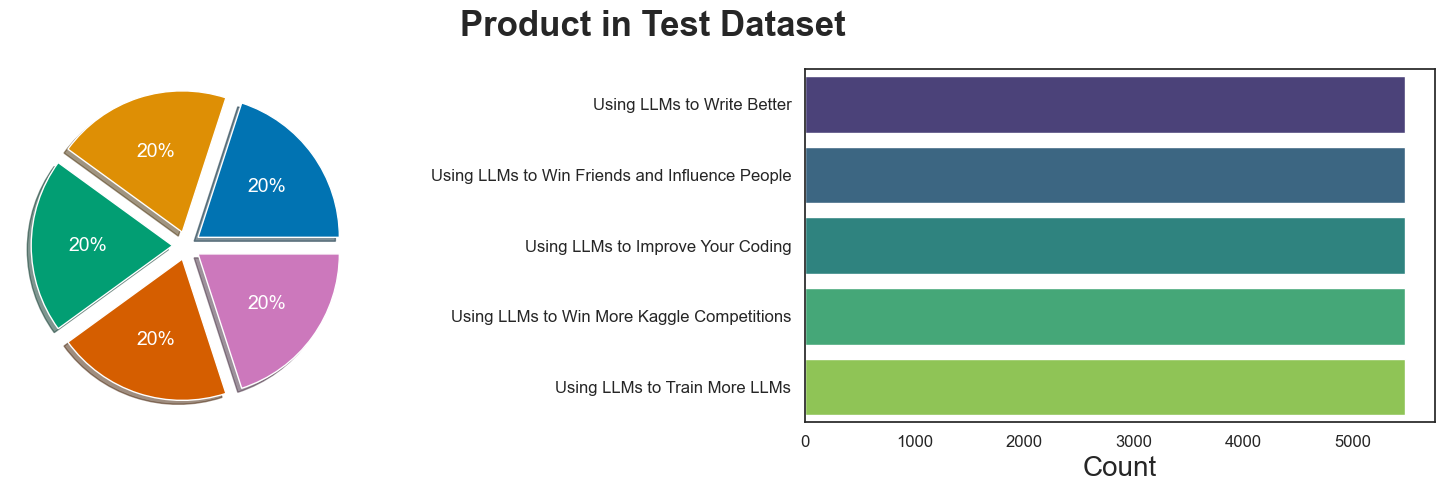

In [32]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten()

ax[0].pie(
    test['product'].value_counts(), 
    shadow = True, 
    explode = [.1 for i in range(0, 5)], 
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data = test, y = 'product', ax = ax[1], palette = 'viridis', order = test['product'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Product in Test Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

### Split de las series temporales
A diferencia de otros problemas de ML, al trabajar con series temporales, no podemos seleccionar muestras aleatorias para el conjunto de prueba. En su lugar, es crucial dividir los datos de manera secuencial, utilizando una división de tiempo, donde el conjunto de prueba sigue cronológicamente al conjunto de entrenamiento.

In [34]:
class CustomTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // (self.n_splits + 1)
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size * 2
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

### Métrica: SMAPE

In [37]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

## Preparación para el entrenamiento

In [38]:
X = train.copy()
y = X.pop('num_sold')
y = np.log1p(y)

seed = 42
k = TimeSeriesSplit(n_splits = 7, test_size = 13695)

np.random.seed(seed)

## Procesamiento de fechas
Crearemos una clase para que sea más sencillo el proceso fit/transform.

In [39]:
class DateProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, x, y = None): 
        return self
    def transform(self, x, y = None):
        x_copy = x.copy()
        x_copy['day'] = x_copy.date.dt.day
        x_copy['month'] = x_copy.date.dt.month
        x_copy['year'] = x_copy.date.dt.year
        x_copy['dow'] = x_copy.date.dt.dayofweek
        x_copy = x_copy.drop('date', axis = 1)
        return x_copy     

## Validación cruzada personalizada
Para detectar fácilmente overfitting

In [41]:
def cross_val_score(model, cv = k, label = ''):
    
    X = train.copy()
    y = X.pop('num_sold')
    y = np.log1p(y)
    
    #initiate prediction arrays and score lists
    val_predictions = np.zeros((len(train)))
    #train_predictions = np.zeros((len(train)))
    train_scores, val_scores = [], []
    
    #training model, predicting prognosis probability, and evaluating log loss
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
        #define train set
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        
        #define validation set
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
        
        #train model
        model.fit(X_train, y_train)
        
        #make predictions
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
                  
        val_predictions[val_idx] += val_preds
        
        #reverse log-transformation
        y_train = np.expm1(y_train)
        y_val = np.expm1(y_val)
        
        train_preds = np.expm1(train_preds)
        val_preds = np.expm1(val_preds)
        
        #evaluate model for a fold
        train_score = smape(y_train, train_preds)
        val_score = smape(y_val, val_preds)
        
        #append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)
    
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
    
    return val_scores, val_predictions

# Modelos
Evitamos XGBoost porque no trabaja bien cuando la métrica es MAE (y SMAPE está relacionada con MAE)

In [42]:
score_list, oof_list = pd.DataFrame(), pd.DataFrame()

models = [
    ('lgb', LGBMRegressor(random_state = seed, objective = 'mae')),
    ('cb', CatBoostRegressor(random_state = seed, verbose = 0, objective = 'MAE')),
    ('gb', GradientBoostingRegressor(random_state = seed, loss = 'absolute_error')),
    ('hgb', HistGradientBoostingRegressor(random_state = seed, loss = 'absolute_error'))
]

Encoder = GLMMEncoder(cols = ['country', 'store', 'product'], random_state = seed)

In [43]:
for (label, model) in models:
     score_list[label], oof_list[label] = cross_val_score(
         make_pipeline(DateProcessor(), Encoder, model),
         label = label,
     )

Val Score: 16.77297 ± 10.30141 | Train Score: 5.54579 ± 0.25206 | lgb
Val Score: 13.94477 ± 8.35631 | Train Score: 4.56653 ± 0.10894 | cb
Val Score: 16.23843 ± 7.63947 | Train Score: 8.82280 ± 0.48609 | gb
Val Score: 17.13217 ± 11.04157 | Train Score: 5.54249 ± 0.24108 | hgb


### Comparamos las puntuaciones

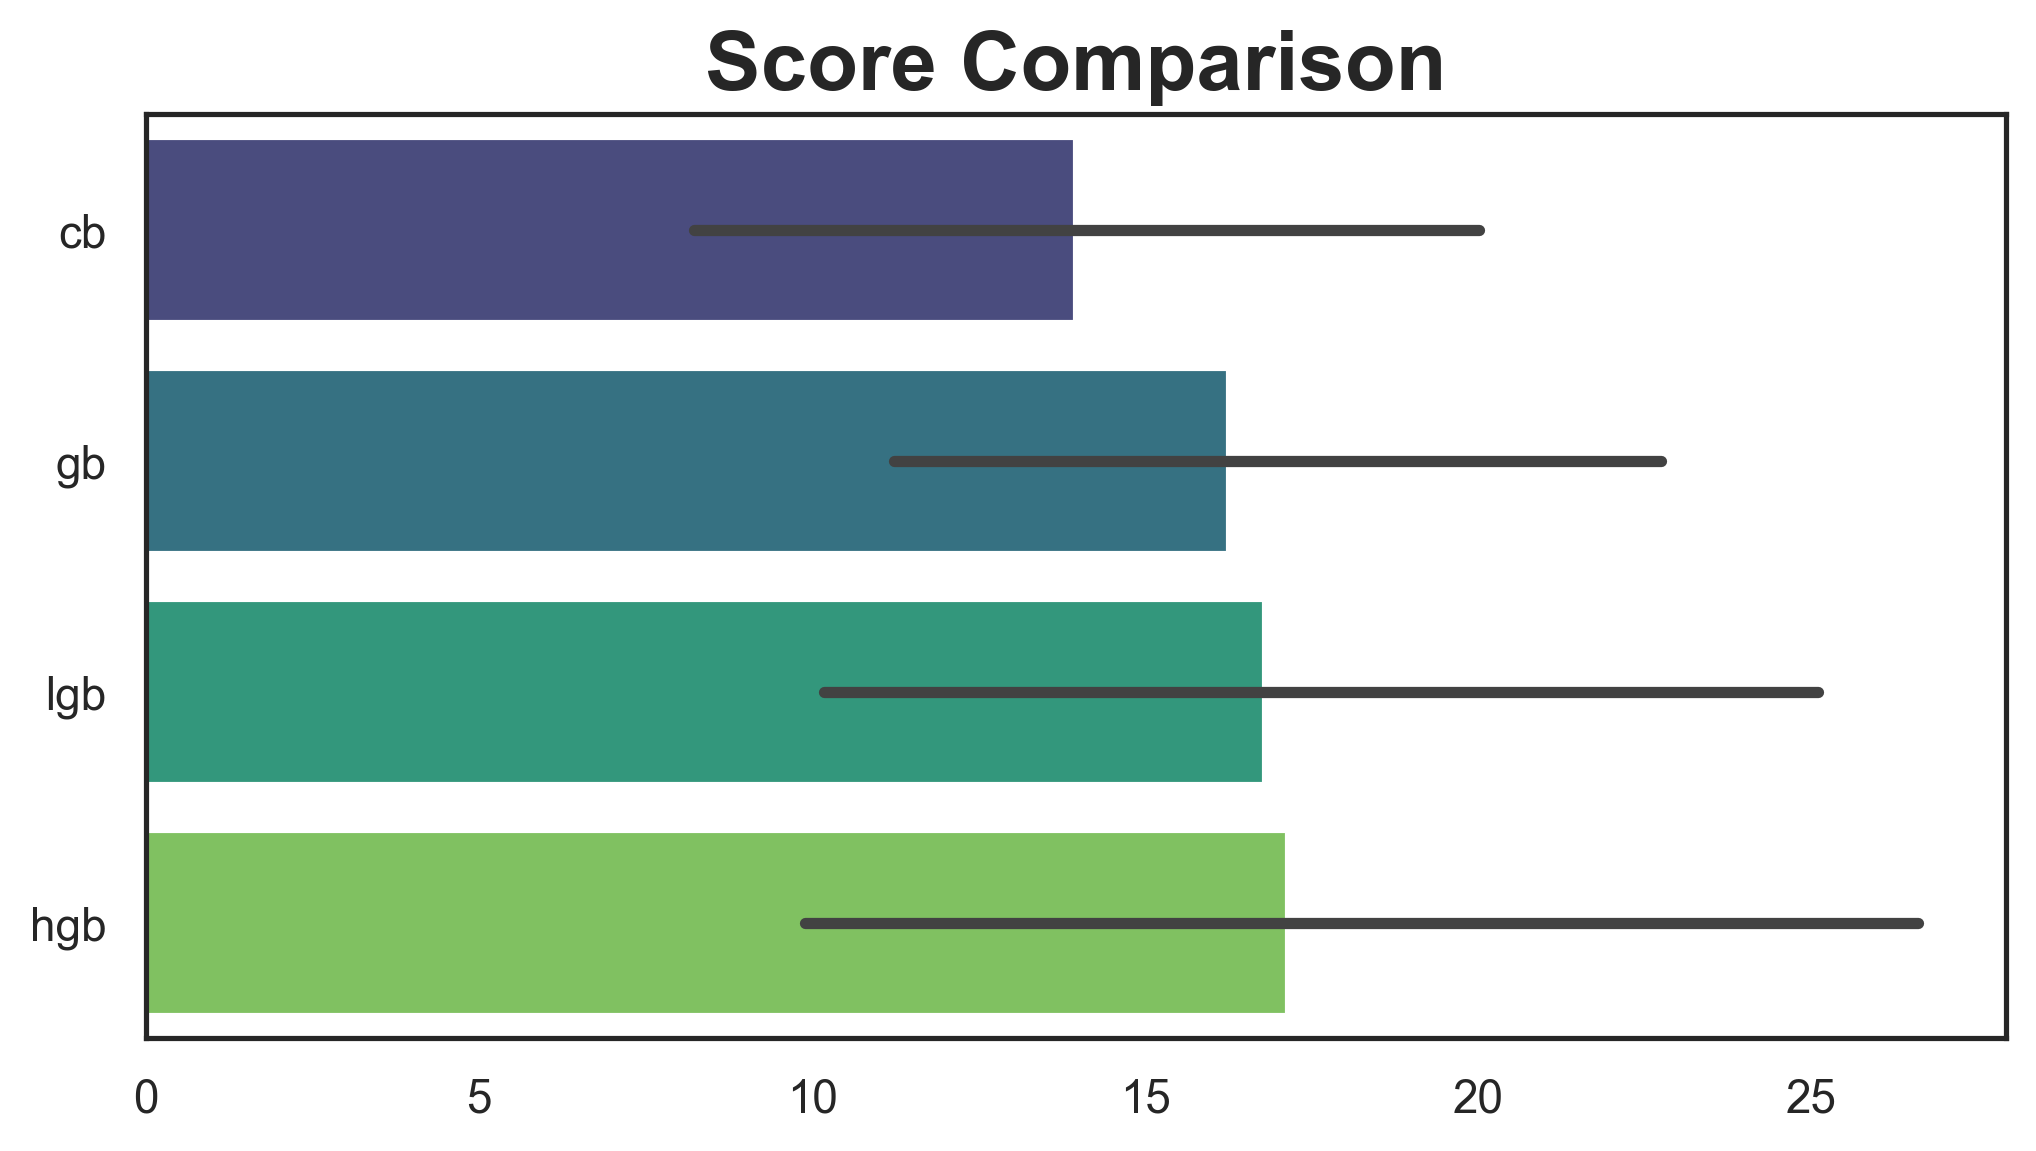

In [44]:
plt.figure(figsize = (8, 4), dpi = 300)
sns.barplot(data = score_list.reindex((score_list).mean().sort_values().index, axis = 1), palette = 'viridis', orient = 'h')
plt.title('Score Comparison', weight = 'bold', size = 20)
plt.show()

# Re entrenamos con todo el dataset
Para no perder ningún dato de entrenamiento

In [45]:
model = make_pipeline(DateProcessor(), Encoder, HistGradientBoostingRegressor(random_state = seed, loss = 'absolute_error'))

model.fit(X, y)
prediction = model.predict(test)

# Submission

In [46]:
submission = test.drop(list(test.drop('id', axis = 1)), axis = 1)

submission['num_sold'] = np.expm1(prediction) * 1.5
submission.to_csv('submission.csv', index = False)